In [154]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA  # to apply PCA

In [155]:
# save filepath 
home_data_file_path = '/Users/balqeesjabri/Downloads/train.csv'
# read the data and store data in DataFrame home_data
home_data = pd.read_csv(home_data_file_path)


It is a supervised problem since the dataset includes labeled examples where each data point has a corresponding target variable( house price in this case)

The target variable is continuous (i.e numerical value house price), therefore, it is a regression problem

In [156]:
# target
y = home_data.SalePrice
X = home_data.drop(['SalePrice'], axis=1)
# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                                                random_state=0)

In [157]:

avg_price = np.mean(y)
# will come in handy to see how far off is metric score
print(avg_price)

180921.19589041095


In [158]:
categorical_cols = [colname for colname in X_train_full.columns if X_train_full[colname].dtype == "object"]

# Select numerical columns
numerical_cols = [colname for colname in X_train_full.columns if X_train_full[colname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [159]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Create transformers for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
# Create transformers for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Create a ColumnTransformer to apply different transformers to both feature types
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])





In [160]:
# Define the Model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=250, random_state=55)

1. n_estimators=100, random_state=0:  rmse: 31320.64408937722
2. n_estimators=300, random_state=0:  rmse: 31240.181525443895
3. n_estimators=300, random_state=42: rmse: 30848.3330883714
4. n_estimators=400, random_state=42  rmse: 30675.564025063748
5. n_estimators=400, random_state=55  rmse: 30068.437446816566
6. n_estimators=250, random_state=55  rmse: 29866.344956563484

In [161]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a pipline 
# In this pipeline, preprocessor and model are transformers (defined in the previous step)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
# This line fits the pipeline to the training data,
my_pipeline.fit(X_train, y_train)

# # Preprocessing of validation data, get predictions
# # notice here how we didnt have to preprocess the X_valid data for data trans(imputaion/OH ENCODING)
preds = my_pipeline.predict(X_valid)

# # Evaluate the model
score = mean_absolute_error(y_valid, preds)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print('rmse:', rmse)

rmse: 29866.344956563484


 Select the best components
For this, we need to run the PCA algorithm once by keeping all the components to make the cumulative explained variance plot which is extremely useful to find the optimal number of principal components.

In [162]:
# Step 1: Preprocess the data using the preprocessor
X_train_preprocessed = preprocessor.transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

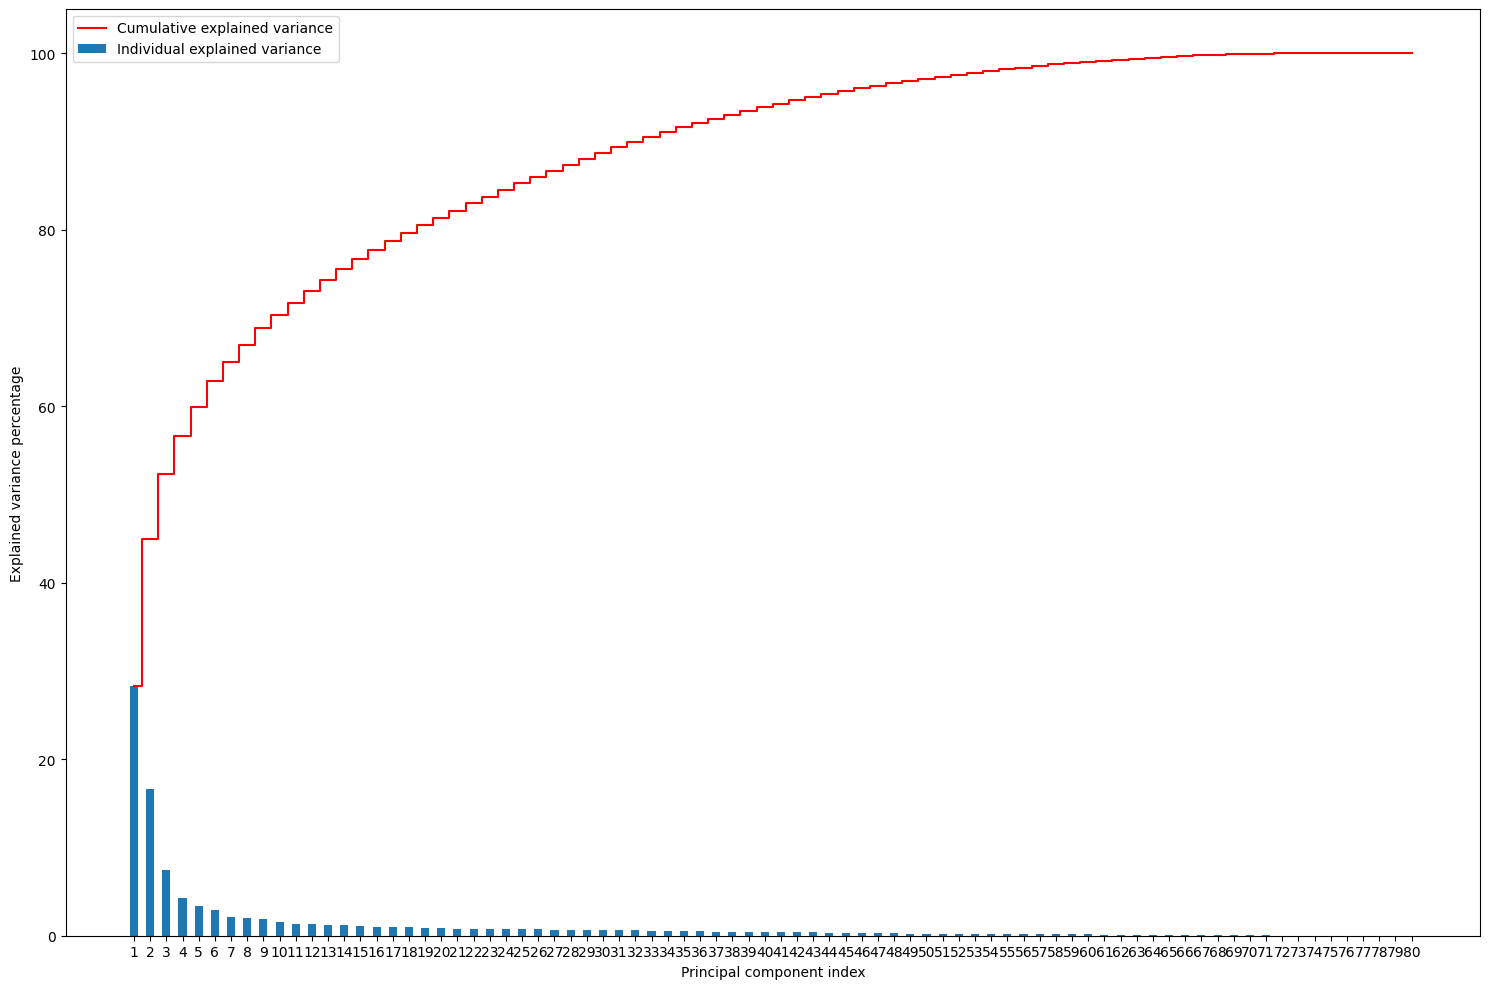

In [163]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(X_train_preprocessed)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)
plt.figure(figsize=(15, 10))
plt.bar(range(1, 81), exp_var, align='center',
        label='Individual explained variance', width=0.5)
plt.step(range(1, 81), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, 81)))
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("cumulative_explained_variance_plot.png")

In [164]:
from sklearn.decomposition import PCA
pca = PCA(n_components=49)
X_pca = pd.DataFrame(pca.fit_transform(X_train_preprocessed)
)
# Step 3: Split the PCA-transformed data and target labels into training and test sets (if not already done)
X_train_pca, X_valid_pca, y_train, y_valid = train_test_split(X_pca, y_train, random_state=50)

1. n_components=49, random_state=50, n_estimators=270, random_state=56: .Root Mean Squared Error 28215.889646553864
2. n_components=49, random_state=50, n_estimators=260, random_state=56: Root Mean Squared Error (RMSE): 28269.83075829938
3. n_components=49, random_state=50, n_estimators=250, random_state=55: Root Mean Squared Error (RMSE): 28761.161209301812
4. n_components=49, random_state=52, n_estimators=250, random_state=55: Root Mean Squared Error (RMSE): 31470.60931456694
5. n_components=49, random_state=55, n_estimators=250, random_state=55: Root Mean Squared Error (RMSE): 33693.5753244074
6. n_components=49, random_state=42, n_estimators=250, random_state=55: Root Mean Squared Error (RMSE): 33797.26185819406
7. n_components=52, random_state=42, n_estimators=250, random_state=55: Root Mean Squared Error (RMSE): 34493.369772068065
8. LAST RMSE SCORE: 28189.479367777698


In [165]:
from sklearn.ensemble import RandomForestRegressor
# define model
model = RandomForestRegressor(n_estimators=270, random_state=56)

In [166]:
# Train the model on the training data
model.fit(X_train_pca, y_train)

RandomForestRegressor(n_estimators=270, random_state=56)

In [167]:
#  Make predictions on the test data
y_pred = model.predict(X_valid_pca)

In [168]:
# Evaluate the model's performance using regression metrics

score = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Mean Absolute Error (MAE):", score)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 19904.19270072993
Root Mean Squared Error (RMSE): 28189.479367777698


In [169]:
print("Transformed dataset size:", X_pca.shape)

Transformed dataset size: (1095, 49)
